# SQL Parser using Lark
### Lark
- Ref: [Lark Documentation](https://lark-parser.readthedocs.io/en/latest/)
  - Repo: [lark-parser](https://github.com/lark-parser/lark)

### Lark SQL Parser
- Ref: [sql_to_ibis](https://github.com/zbrookle/sql_to_ibis)
- Ref: [ibis](https://github.com/ibis-project/ibis)
  - Docs: https://ibis-project.org/docs/dev/

`sql_to_ibis` is a [Python](https://www.python.org/) package that translates SQL syntax into [ibis](https://github.com/ibis-project/ibis) expressions. This provides the capability of using only one SQL dialect to target many different backends.

- Ref: From `sql_to_ibis` project `sql_select_query.py`
- Ref: SQL grammar file <https://github.com/zbrookle/sql_to_ibis/tree/main/sql_to_ibis/grammar>

## Just Enough SQL
We may not need the full SQL parser and transform for our purpose. We can simply extract the `SELECT` statement.

In [1]:
%matplotlib inline

import os
_ROOT = "../firesql/sql"
GRAMMAR_PATH = os.path.join(_ROOT, "grammar", "firesql.lark")
with open(file=GRAMMAR_PATH) as sql_grammar_file:
    _GRAMMAR_TEXT = sql_grammar_file.read()

In [2]:
from lark import Lark, tree
parser = Lark(_GRAMMAR_TEXT, parser="lalr")

In [3]:
sql = """select id,date,email from Bookings where date = '2022-04-04T00:00:00'"""
ast = parser.parse(sql)

In [4]:
print( ast.pretty() )

final
  sql_expr
    select
      select_all
        select_list
          select_expression
            column_name
              None
              name	id
            None
          select_expression
            column_name
              None
              name	date
            None
          select_expression
            column_name
              None
              name	email
            None
      from_clause
        from_expression
          table_name
            name	Bookings
            None
      where_clause
        bool_expression
          bool_parentheses
            comparison_type
              equals
                column_name
                  None
                  name	date
                string	'2022-04-04T00:00:00'



### Display Parse Tree
- Ref: Example of displaying parse tree <https://github.com/lark-parser/lark/blob/master/examples/fruitflies.py>

Install `pydot`
```
pip install pydot
```

Also, the backend requires `graphviz` to render, for Mac M1
```
arch -x86_64 brew install graphviz
```

In [5]:
# need `pip install pydot` and `brew install graphviz` installed
def make_png(filename, sql):
    tree.pydot__tree_to_png( parser.parse(sql), filename)

def make_dot(filename, sql):
    tree.pydot__tree_to_dot( parser.parse(sql), filename)

In [6]:
PARSE_TREE_FILE = 'sql_parse_tree.png'
make_png(PARSE_TREE_FILE, sql)

ModuleNotFoundError: No module named 'pydot'

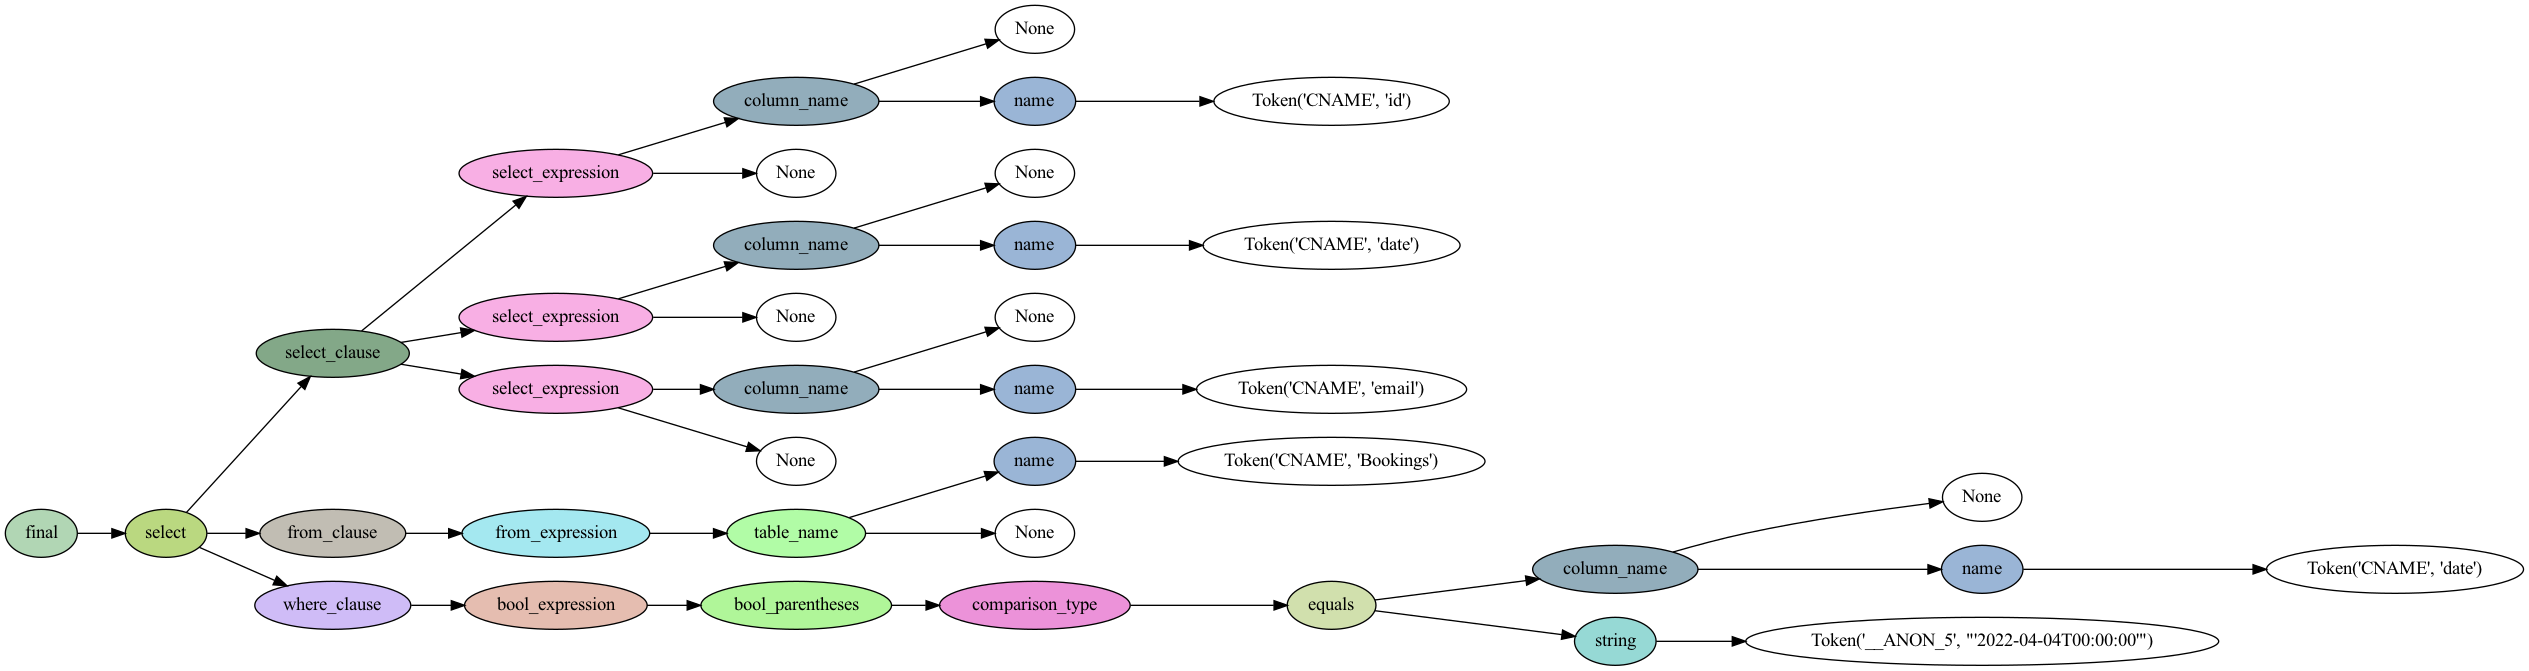

In [ ]:
from IPython.display import Image
Image(filename=PARSE_TREE_FILE)

### Visitor, Transformer or Interpreter
Transformers & Visitors provide a convenient interface to process
the parse-trees that Lark returns.

#### Visitors
* **Visitors** - visit each node of the tree, and run the appropriate method on it according to the node’s data. They work bottom-up, starting with the leaves and ending at the root of the tree.
* **Interpreter** - is also considered as a form of visiting. Interpreter walks the tree starting at the root. Visits the tree, starting with the root and finally the leaves (top-down)

In [ ]:
from lark import Visitor

class TreeVisitor(Visitor):
  selects = []
  wheres = []
  tables = []

  def select_expression(self, s, *args):
    field = s.children[0].children[1].children[0]
    self.selects.append(field.value)

  def comparison_type(self, s):
    op = s.children[0].data
    field = s.children[0].children[0].children[1].children[0]
    value = s.children[0].children[1].children[0]
    self.wheres.append((field.value, op.value, value.value))

  def from_expression(self, s):
    table = s.children[0].children[0].children[0]
    self.tables.append(table.value)

visitor = TreeVisitor()
result = visitor.visit(ast)

In [ ]:
print(f'SELECT {visitor.selects} FROM {visitor.tables}')
print(f'    WHERE {visitor.wheres}')

SELECT ['id', 'date', 'email'] FROM ['Bookings']
    WHERE [('date', 'equals', "'2022-04-04T00:00:00'")]


> Using Visitor is simple at first, but you need to know exactly what you're fetching, the children chain can be difficult to navigate depending on the grammar which produce the parsed tree.

## Transform into Firebase Query
### Transformers
* **Transformers** -  work bottom-up (or depth-first), starting with visiting the leaves and working their way up until ending at the root of the tree.
  * For each node visited, the transformer will call the appropriate method (callbacks), according to the node’s `data`, and use the returned value to replace the node, thereby creating a new tree structure.
  * Transformers can be used to implement map & reduce patterns. Because nodes are reduced from leaf to root, at any point the callbacks may assume the children have already been transformed

In [2]:
from firesql.firebase import FirebaseClient
from firesql.sql.sql_fire_client import FireSQLClient

firebaseClient = FirebaseClient()
firebaseClient.connect(credentials_json='../credentials/credentials.json')

# create FireSQLClient that is using the FireSQLAbstractClient interface.
client = FireSQLClient(firebaseClient)

In [3]:
import os
from lark import Lark, tree

_ROOT = "../firesql/sql"
GRAMMAR_PATH = os.path.join(_ROOT, "grammar", "firesql.lark")
with open(file=GRAMMAR_PATH) as sql_grammar_file:
    _GRAMMAR_TEXT = sql_grammar_file.read()
parser = Lark(_GRAMMAR_TEXT, parser="lalr")

In [44]:
from firesql.sql.sql_transformer import SQLTransformer

company = 'bennycorp'

sql1 = """
  SELECT docid, email, state
    FROM
      Companies/{}/Users
    WHERE
      state IN ('ACTIVE')
""".format(company)

sql2 = """
  SELECT *
    FROM
      Companies/{}/Users
    WHERE
      state IN ('ACTIVE')
""".format(company)

sql3 = """
  SELECT u.email, u.state, b.date, b.state
    FROM
      Companies/{}/Users as u JOIN Companies/{}/Bookings as b
      ON u.email = b.email
    WHERE 
      u.state IN ('ACTIVE') and
      b.state IN ('CHECKED_IN', 'CHECKED_OUT') and
      b.date >= '2022-03-18T04:00:00'
""".format(company, company)

sql4 = """
  SELECT docid, email, state
    FROM
      Companies/{}/Users
    WHERE
      state IN ('ACTIVE') and
      email NOT LIKE '%twotwo%'
""".format(company)

sql5 = """
  SELECT docid, email, state
    FROM
      Companies/{}/Bookings
    WHERE
      "coordinate.Building.displayName" = 'Work From Home'
""".format(company)

sql6 = """
  SELECT docid, email, roles
    FROM
      Companies/{}/Users
    WHERE
      roles ANY CONTAIN ('ROOT', 'CLEANER')
""".format(company)

sql7 = """
  SELECT docid, email
    FROM
      Companies/{}/Users
    WHERE
      vaccination IS NULL
""".format(company)

sql8 = """
  SELECT COUNT(*)
    FROM
      Companies/{}/Users
""".format(company)

sql9 = """
  SELECT ALL DISTINCT email, state
    FROM
      Companies/{}/Bookings
    WHERE
      date > '2022-03-18T00:00:00'
""".format(company)

ast = parser.parse(sql9)
statements = SQLTransformer().transform(ast)
statements[0]

SQL_Select(mode='alldistinct', columns=[SQL_ColumnRef(table=None, column='email', func=None), SQL_ColumnRef(table=None, column='state', func=None)], froms=[SQL_SelectFrom(part='Companies/bennycorp/Bookings', alias=None)], where=SQL_BinaryExpression(operator='>', left=SQL_ColumnRef(table=None, column='date', func=None), right=SQL_ValueDateTime(value=datetime.datetime(2022, 3, 18, 0, 0))))

In [45]:
from firesql.sql import SQLFireQuery       

fireQuery = SQLFireQuery()
queries = fireQuery.generate(statements[0], options={})

In [46]:
print(fireQuery.aliases)
print(fireQuery.collectionFields)
print(fireQuery.aggregationFields)
print(fireQuery.on)
print(fireQuery.columnNameMap)
print(fireQuery.collections)
print(queries)

{'Companies/bennycorp/Bookings': 'Companies/bennycorp/Bookings'}
{'Companies/bennycorp/Bookings': ['email', 'state']}
{'Companies/bennycorp/Bookings': []}
None
{'Companies/bennycorp/Bookings': {'email': 'email', 'state': 'state'}}
{'Companies/bennycorp/Bookings': 'Companies/bennycorp/Bookings'}
{'Companies/bennycorp/Bookings': [['date', '>', datetime.datetime(2022, 3, 18, 0, 0)]]}


In [47]:
fireQueries = fireQuery.firebase_queries(queries)
fireQueries

{'Companies/bennycorp/Bookings': [['date',
   '>',
   datetime.datetime(2022, 3, 18, 0, 0)]]}

In [48]:
filterQueries = fireQuery.filter_queries(queries)
filterQueries

{'Companies/bennycorp/Bookings': []}

In [49]:
documents = fireQuery.execute_query(client, fireQueries)

In [50]:
filterDocs = fireQuery.filter_documents(documents, filterQueries)
filterDocs

{'Companies/bennycorp/Bookings': {'Ei6RpCt6hdi2a6Glms0W': {'userExternalId': None,
   'email': 'btscheung+bennycorp@gmail.com',
   'visitor': {'company': 'jonahgroup',
    'phone': '4161111111',
    'email': 'ilya.baykhuzin@jonahgroup.com',
    'lastName': '',
    'firstName': 'ilya',
    'reason': None},
   'groups': ['LfAGvjapecZX2Gr1Yjz3'],
   'state': 'CANCELED',
   'locationType': 'Building',
   'events': [{'event': 'CREATION',
     'source': 'hive-gate-web',
     'date': DatetimeWithNanoseconds(2022, 3, 18, 19, 33, 22, 878000, tzinfo=datetime.timezone.utc),
     'sourceUser': 'btscheung+bennycorp@gmail.com'},
    {'new_state': 'CONFIRMED',
     'date': DatetimeWithNanoseconds(2022, 3, 18, 19, 33, 22, 878000, tzinfo=datetime.timezone.utc),
     'old_state': 'CONFIRMED',
     'event': 'STATE_CHANGE'},
    {'new_state': 'CANCELED',
     'sourceUser': 'hive.jonah+hiveapp@gmail.com',
     'date': DatetimeWithNanoseconds(2022, 3, 18, 19, 33, 26, 778000, tzinfo=datetime.timezone.utc),
 

In [51]:
selectDocs = fireQuery.post_process(filterDocs)
len(selectDocs)

8

In [52]:
fireQuery.select_fields()

['email', 'state']

In [53]:
from firesql.sql import DocPrinter

docPrinter = DocPrinter()
docPrinter.printCSV(selectDocs, fireQuery.select_fields())

"email","state"
"btscheung+bennycorp@gmail.com","CANCELED"
"btscheung+bennycorp@gmail.com","CHECKED_IN"
"btscheung+bennycorp@gmail.com","CONFIRMED"
"btscheung+twotwo@gmail.com","CONFIRMED"
"btscheung+real@gmail.com","CONFIRMED"
"btscheung+hill6@gmail.com","CHECKED_IN"
"btscheung+hill6@gmail.com","INVITED"
"btscheung+threethree@gmail.com","CONFIRMED"
